In [1]:
import numpy as np
from scipy.stats import bernoulli

class LinPHEStruct:
    def __init__(self, featureDimension, lambda_, epsilon, alpha):
        self.d = featureDimension
        self.A = lambda_ * np.identity(n=self.d)
        self.lambda_ = lambda_
        self.epsilon = epsilon
        self.alpha = alpha
        self.b = np.zeros(self.d)
        self.AInv = np.linalg.inv(self.A)
        self.UserTheta = np.zeros(self.d)
        self.UserArmTrials = np.zeros(self.d)
        self.time = 0

    def updateParameters(self, articlePicked_id, articlePicked_FeatureVector, click):
        self.A += np.outer(articlePicked_FeatureVector, articlePicked_FeatureVector) * (self.alpha + 1)
        self.b += articlePicked_FeatureVector * (click + bernoulli.rvs(0.5))
        self.AInv = np.linalg.inv(self.A)
        self.UserTheta = np.dot(self.AInv, self.b)
        self.UserArmTrials[articlePicked_id] += 1
        self.time += 1

    def getTheta(self):
        return self.UserTheta

    def getA(self):
        return self.A

    def decide(self, pool_articles):
        for article in pool_articles:
            if self.UserArmTrials[article.id] == 0:
                return article

        # print("EpsilonGreedy: greedy")
        maxPTA = float('-inf')
        articlePicked = None

        for article in pool_articles:
            article_pta = np.dot(self.UserTheta, article.featureVector)
            # pick article with highest Prob
            if maxPTA < article_pta:
                articlePicked = article
                maxPTA = article_pta

        return articlePicked
        
class PerturbedHistoryExplorationLinearBandit:
    def __init__(self, dimension, lambda_, epsilon, alpha):
        self.users = {}
        self.dimension = dimension
        self.lambda_ = lambda_
        self.epsilon = epsilon
        self.alpha = alpha
        self.CanEstimateUserPreference = True

    def decide(self, pool_articles, userID):
        if userID not in self.users:
            self.users[userID] = LinPHEStruct(self.dimension, self.lambda_, self.epsilon, self.alpha)

        return self.users[userID].decide(pool_articles)

    def updateParameters(self, articlePicked, click, userID):
        self.users[userID].updateParameters(articlePicked.id, articlePicked.featureVector[:self.dimension], click)

    def getTheta(self, userID):
        return self.users[userID].UserTheta




In [703]:
import numpy as np
from scipy.stats import bernoulli

class PHEStruct:
    def __init__(self, num_arm, epsilon, alpha):
        self.d = num_arm
        self.epsilon = epsilon
        self.alpha = alpha
        self.UserArmMean = np.zeros(self.d)
        self.PerturbedUserArmMean = np.zeros(self.d)
        self.UserArmTrials = np.zeros(self.d)

        self.time = 0

    def updateParameters(self, articlePicked_id, click):
        self.UserArmMean[articlePicked_id] = (self.UserArmMean[articlePicked_id]*self.UserArmTrials[articlePicked_id] + click) / (self.UserArmTrials[articlePicked_id]+1)
        self.PerturbedUserArmMean[articlePicked_id] = (self.UserArmMean[articlePicked_id] + \
                                                       bernoulli.rvs(0.5)) / (1+ self.alpha)
        self.UserArmTrials[articlePicked_id] += 1
        self.time += 1

    def getTheta(self):
        return self.UserArmMean

    def decide(self, pool_articles):
        for article in pool_articles:
            if self.UserArmTrials[article.id] == 0:
                return article
        
        argmax = np.argmax(self.PerturbedUserArmMean)
        return [i for i in pool_articles if i.id ==argmax][0] # Action that maximizes upper confidence bound


class PerturbedHistoryExplorationMultiArmedBandit:
    def __init__(self, num_arm, epsilon, alpha):
        self.users = {}
        self.num_arm = num_arm
        self.epsilon = epsilon
        self.alpha = alpha
        self.CanEstimateUserPreference = False

    def decide(self, pool_articles, userID):
        if userID not in self.users:
            self.users[userID] = PHEStruct(self.num_arm, self.epsilon, self.alpha)

        return self.users[userID].decide(pool_articles)

    def updateParameters(self, articlePicked, click, userID):
        self.users[userID].updateParameters(articlePicked.id, click)

    def getTheta(self, userID):
        return self.users[userID].UserArmMean



In [841]:
import numpy as np

class LinThompsonSamplingStruct:
    def __init__(self, featureDimension, lambda_, epsilon, sigma):
        self.d = featureDimension
        self.A = lambda_ * np.identity(n=self.d) #d-dim identity matrix
        self.lambda_ = lambda_
        self.epsilon = epsilon
        self.b = np.zeros(self.d)
        self.AInv = np.linalg.inv(self.A)
        self.UserTheta = np.random.multivariate_normal(np.zeros(self.d), self.A)
        self.sigma = sigma
        self.UserArmTrials = np.zeros(self.d)
        self.time = 0

    def updateParameters(self, articlePicked_id, articlePicked_FeatureVector, click):
#         print(self.UserTheta)
        self.A += (np.outer(articlePicked_FeatureVector, articlePicked_FeatureVector) / (self.sigma ** 2)) 
        self.b += (np.multiply(articlePicked_FeatureVector,click) / (self.sigma ** 2))
        self.AInv = np.linalg.inv(self.A)
        self.UserTheta = np.random.multivariate_normal(np.dot(self.AInv, self.b), self.A) #
        self.UserArmTrials[articlePicked_id] += 1
        self.time += 1

    def getTheta(self):
        return self.UserTheta

    def getA(self):
        return self.A

    def decide(self, pool_articles):
        for article in pool_articles:
            if self.UserArmTrials[article.id] == 0:
                return article
            
        rewards = np.zeros(self.d)
        for article in pool_articles:
            x, x_id = article.featureVector , article.id
            rewards[x_id] = np.dot(x.T, self.UserTheta)

        argmax = np.argmax(rewards)
        return [i for i in pool_articles if i.id ==argmax][0] # Action that maximizes upper confidence bound


class ThompsonSamplingLinearBandit:
    def __init__(self, dimension, lambda_, epsilon, sigma):
        self.users = {}
        self.dimension = dimension
        self.lambda_ = lambda_
        self.epsilon = epsilon
        self.sigma = sigma
        self.CanEstimateUserPreference = True

    def decide(self, pool_articles, userID):
        if userID not in self.users:
            self.users[userID] = LinThompsonSamplingStruct(self.dimension, self.lambda_, self.epsilon, self.sigma)

        return self.users[userID].decide(pool_articles)

    def updateParameters(self, articlePicked, click, userID):
        self.users[userID].updateParameters(articlePicked.id, articlePicked.featureVector[:self.dimension], click)

    def getTheta(self, userID):
        return self.users[userID].UserTheta




In [850]:
import numpy as np

class ThompsonSamplingStruct:
    def __init__(self, num_arm, epsilon, sigma):
        self.d = num_arm
        self.epsilon = epsilon
        self.sigma = sigma
        self.UserArmMean = np.zeros(self.d)
        self.UserArmTrials = np.zeros(self.d)

        self.time = 0

    def updateParameters(self, articlePicked_id, click):
        self.UserArmMean[articlePicked_id] = (self.UserArmMean[articlePicked_id]*self.UserArmTrials[articlePicked_id] + click) / (self.UserArmTrials[articlePicked_id]+1)
        self.UserArmTrials[articlePicked_id] += 1

        self.time += 1

    def getTheta(self):
        return self.UserArmMean

    def decide(self, pool_articles):
        for article in pool_articles:
            if self.UserArmTrials[article.id] == 0:
                return article

        posterior = np.zeros(self.d)
        for article in pool_articles:
            x, x_id = article.featureVector , article.id
            posterior[x_id] = np.random.normal(self.UserArmMean[x_id], self.sigma, 1)
        print('posterior', posterior)
        argmax = np.argmax(posterior)
        print('argmax', argmax)
        return [i for i in pool_articles if i.id ==argmax][0] #
        

class ThompsonSamplingMultiArmedBandit:
    def __init__(self, num_arm, epsilon, sigma):
        self.users = {}
        self.num_arm = num_arm
        self.epsilon = epsilon
        self.sigma = sigma
        self.CanEstimateUserPreference = True

    def decide(self, pool_articles, userID):
        if userID not in self.users:
            self.users[userID] = ThompsonSamplingStruct(self.num_arm, self.epsilon, self.sigma)

        return self.users[userID].decide(pool_articles)

    def updateParameters(self, articlePicked, click, userID):
        self.users[userID].updateParameters(articlePicked.id, click)

    def getTheta(self, userID):
        return self.users[userID].UserArmMean



In [847]:
import copy
import numpy as np
from random import sample, shuffle
import datetime
import os.path
import matplotlib.pyplot as plt
import argparse
# local address to save simulated users, simulated articles, and results
from conf import sim_files_folder, save_address
from util_functions import featureUniform, gaussianFeature
from Articles import ArticleManager
from Users import UserManager

from lib.EpsilonGreedyLinearBandit import EpsilonGreedyLinearBandit
from lib.EpsilonGreedyMultiArmedBandit import EpsilonGreedyMultiArmedBandit
from lib.UCBMultiArmedBandit import UCBMultiArmedBandit
from lib.UCBLinearBandit import UCBLinearBandit


class simulateOnlineData(object):
	def __init__(self, context_dimension, testing_iterations, plot, articles,
				 users, noise=lambda: 0, signature='', NoiseScale=0.0, poolArticleSize=None):

		self.simulation_signature = signature

		self.context_dimension = context_dimension
		self.testing_iterations = testing_iterations
		self.batchSize = 1

		self.plot = plot

		self.noise = noise

		self.NoiseScale = NoiseScale
		
		self.articles = articles
		self.users = users

		if poolArticleSize is None:
			self.poolArticleSize = len(self.articles)
		else:
			self.poolArticleSize = poolArticleSize

	def getTheta(self):
		Theta = np.zeros(shape = (self.context_dimension, len(self.users)))
		for i in range(len(self.users)):
			Theta.T[i] = self.users[i].theta
		return Theta
	
	def batchRecord(self, iter_):
		print("Iteration %d"%iter_, " Elapsed time", datetime.datetime.now() - self.startTime)

	def getReward(self, user, pickedArticle):
		return np.dot(user.theta, pickedArticle.featureVector)

	def GetOptimalReward(self, user, articlePool):		
		maxReward = float('-inf')
		maxx = None
		for x in articlePool:	 
			reward = self.getReward(user, x)
			if reward > maxReward:
				maxReward = reward
				maxx = x
		return maxReward, maxx
	
	def getL2Diff(self, x, y):
		return np.linalg.norm(x-y) # L2 norm

	def regulateArticlePool(self):
		# Randomly generate articles
		self.articlePool = sample(self.articles, self.poolArticleSize)

	def runAlgorithms(self, algorithms):
		self.startTime = datetime.datetime.now()
		timeRun = self.startTime.strftime('_%m_%d_%H_%M') 
		filenameWriteRegret = os.path.join(save_address, 'AccRegret' + timeRun + '.csv')
		filenameWritePara = os.path.join(save_address, 'ParameterEstimation' + timeRun + '.csv')

		tim_ = []
		BatchCumlateRegret = {}
		AlgRegret = {}
		ThetaDiffList = {}
		ThetaDiff = {}
		
		# Initialization
		userSize = len(self.users)
		for alg_name, alg in algorithms.items():
			AlgRegret[alg_name] = []
			BatchCumlateRegret[alg_name] = []
			if alg.CanEstimateUserPreference:
				ThetaDiffList[alg_name] = []

		with open(filenameWriteRegret, 'w') as f:
			f.write('Time(Iteration)')
			f.write(',' + ','.join([str(alg_name) for alg_name in algorithms.keys()]))
			f.write('\n')
		
		with open(filenameWritePara, 'w') as f:
			f.write('Time(Iteration)')
			f.write(','+ ','.join([str(alg_name)+'Theta' for alg_name in ThetaDiffList.keys()]))
			f.write('\n')

		for iter_ in range(self.testing_iterations):
			# prepare to record theta estimation error
			for alg_name, alg in algorithms.items():
				if alg.CanEstimateUserPreference:
					ThetaDiff[alg_name] = 0

			for u in self.users:
				self.regulateArticlePool()
				noise = self.noise()
				#get optimal reward for user x at time t
				OptimalReward, OptimalArticle = self.GetOptimalReward(u, self.articlePool)
				OptimalReward += noise

				for alg_name, alg in algorithms.items():
# 					print('-' * 50)
					pickedArticle = alg.decide(self.articlePool, u.id)
					reward = self.getReward(u, pickedArticle) + noise
# 					print('Optimal Article:', OptimalArticle.id)
# 					print('Optimal Reward:', OptimalReward)
# 					print('Reward:', reward)

					alg.updateParameters(pickedArticle, reward, u.id)

					regret = OptimalReward - reward  # pseudo regret, since noise is canceled out
# 					print('Regret:', regret)

					AlgRegret[alg_name].append(regret)

					#update parameter estimation record
					if alg.CanEstimateUserPreference:
# 						print('true theta:', u.theta)      
# 						print('alg theta:', alg.getTheta(u.id))                

						ThetaDiff[alg_name] += self.getL2Diff(u.theta, alg.getTheta(u.id))

			for alg_name, alg in algorithms.items():
				if alg.CanEstimateUserPreference:
					ThetaDiffList[alg_name] += [ThetaDiff[alg_name]/userSize]
		
			if iter_%self.batchSize == 0:
				self.batchRecord(iter_)
				tim_.append(iter_)
				for alg_name in algorithms.keys():
					BatchCumlateRegret[alg_name].append(sum(AlgRegret[alg_name])/userSize)

				with open(filenameWriteRegret, 'a+') as f:
					f.write(str(iter_))
					f.write(',' + ','.join([str(BatchCumlateRegret[alg_name][-1]) for alg_name in algorithms.keys()]))
					f.write('\n')
				with open(filenameWritePara, 'a+') as f:
					f.write(str(iter_))
					f.write(','+ ','.join([str(ThetaDiffList[alg_name][-1]) for alg_name in ThetaDiffList.keys()]))
					f.write('\n')

		if (self.plot==True): # only plot
			# plot the results	
			f, axa = plt.subplots(1)
			for alg_name in algorithms.keys():
				axa.plot(tim_, BatchCumlateRegret[alg_name],label = alg_name)
				print('%s: %.2f' % (alg_name, BatchCumlateRegret[alg_name][-1]))
			axa.legend(loc='upper left',prop={'size':9})
			axa.set_xlabel("Iteration")
			axa.set_ylabel("Regret")
			axa.set_title("Accumulated Regret")
			plt.show()

			# plot the estimation error of theta
			f, axa = plt.subplots(1)
			time = range(self.testing_iterations)
			for alg_name, alg in algorithms.items():
				if alg.CanEstimateUserPreference:
					axa.plot(time, ThetaDiffList[alg_name], label = alg_name + '_Theta')
	
			axa.legend(loc='upper right',prop={'size':6})
			axa.set_xlabel("Iteration")
			axa.set_ylabel("L2 Diff")
			axa.set_yscale('log')
			axa.set_title("Parameter estimation error")
			plt.show()

		finalRegret = {}
		for alg_name in algorithms.keys():
			finalRegret[alg_name] = BatchCumlateRegret[alg_name][:-1]
		return finalRegret

Starting for  A-30+AG
Iteration 0  Elapsed time 0:00:00.004986
Iteration 1  Elapsed time 0:00:00.008976
Iteration 2  Elapsed time 0:00:00.019947
Iteration 3  Elapsed time 0:00:00.029919
Iteration 4  Elapsed time 0:00:00.039892
Iteration 5  Elapsed time 0:00:00.049866
Iteration 6  Elapsed time 0:00:00.059839
Iteration 7  Elapsed time 0:00:00.069813
Iteration 8  Elapsed time 0:00:00.080783
Iteration 9  Elapsed time 0:00:00.090757
Iteration 10  Elapsed time 0:00:00.100729
Iteration 11  Elapsed time 0:00:00.110703
Iteration 12  Elapsed time 0:00:00.121673
Iteration 13  Elapsed time 0:00:00.132645
Iteration 14  Elapsed time 0:00:00.143616
Iteration 15  Elapsed time 0:00:00.154586
Iteration 16  Elapsed time 0:00:00.165556
Iteration 17  Elapsed time 0:00:00.176526
Iteration 18  Elapsed time 0:00:00.187498
Iteration 19  Elapsed time 0:00:00.198468
Iteration 20  Elapsed time 0:00:00.209439
Iteration 21  Elapsed time 0:00:00.220409
Iteration 22  Elapsed time 0:00:00.231380
Iteration 23  Elapsed 

posterior [-0.24221103  0.10404335 -0.46365135 -0.26017255 -0.10028264 -0.07151721
 -0.38135084 -0.07293054  0.00519163  0.01924018 -0.10991888  0.20212735
 -0.04991042  0.329512    0.33535781 -0.09550234  0.30758715 -0.03212645
  0.44402483  0.40028674 -0.47149961 -0.02741929 -0.03560727  0.16022612
  0.19800169 -0.1531255   0.24333534 -0.01067835  0.08286329 -0.03035995]
argmax 18
Iteration 48  Elapsed time 0:00:00.551524
posterior [-0.24075399  0.26881501 -0.06673405 -0.26240191  0.08023297  0.11571256
 -0.35796994 -0.09811738  0.10815494 -0.11654423  0.10069227  0.22645426
  0.08184035  0.36696042  0.47919547  0.1309378   0.12854805 -0.02006644
  0.33170447  0.26296708 -0.37750804 -0.02950611  0.18079346  0.11143221
  0.09927433 -0.02657906  0.24166158 -0.10171687  0.04461103 -0.00846236]
argmax 14
Iteration 49  Elapsed time 0:00:00.563492
posterior [-0.1470572   0.24170854 -0.10458403 -0.12798965 -0.01447003 -0.09794956
 -0.20830844 -0.20668299 -0.0526519   0.01132337  0.00084267 

posterior [-0.13020965  0.22332451 -0.05596252 -0.29240984 -0.05238904 -0.05503319
 -0.29369975 -0.09314924  0.05468486 -0.01825405  0.11475203  0.09726173
 -0.04525808  0.417482    0.26322261  0.19043686  0.35317554 -0.04428171
  0.31331877  0.26467395 -0.42386954  0.09277926 -0.00151043  0.16329961
 -0.01436555 -0.28363146  0.16949038 -0.24656492  0.15379677 -0.09091394]
argmax 13
Iteration 75  Elapsed time 0:00:00.964420
posterior [-0.11530702 -0.08464663 -0.09603247 -0.22434773  0.07240938  0.10916131
 -0.41038853 -0.05065118 -0.10108749 -0.08079892 -0.02419594  0.15105271
  0.02791107  0.32193703  0.33224085 -0.02484977  0.38277521  0.05259681
  0.33556095  0.29266052 -0.49882291 -0.05968469 -0.00095771  0.42307339
 -0.02081841 -0.21617963  0.10059848 -0.2035527   0.03878518  0.21569122]
argmax 23
Iteration 76  Elapsed time 0:00:00.977386
posterior [-0.11998735  0.18310563 -0.13392342 -0.35506226 -0.04697516  0.03875282
 -0.2408242  -0.14977114  0.11731296 -0.09118922  0.06170925 

posterior [-0.07297908  0.20635355 -0.27482084 -0.35927479 -0.03687845 -0.05292184
 -0.06695145  0.00070758 -0.11039619 -0.00591349 -0.02911559  0.32150838
 -0.08474016  0.3700929   0.40986772  0.25953398  0.25384897 -0.15127387
  0.10240337  0.3614756  -0.48698181 -0.0907081  -0.11306241  0.11036714
 -0.02176075 -0.20167967  0.18794603 -0.0639111   0.0923875   0.17912601]
argmax 14
Iteration 99  Elapsed time 0:00:01.333434
posterior [-0.18239475  0.14130817 -0.14131295 -0.53602395  0.08283143  0.19373283
 -0.44749198 -0.04440828  0.25865179 -0.06628356 -0.05369584  0.11600039
 -0.06253219  0.41141127  0.36060018  0.02105359  0.24489755 -0.13757223
  0.04680476  0.25844619 -0.44030823 -0.00826303 -0.0568872   0.06099546
 -0.00183982 -0.36849333  0.23305881 -0.14766052 -0.16407929  0.19806662]
argmax 13
Iteration 100  Elapsed time 0:00:01.346398
posterior [-0.07770415  0.25744863 -0.01528592 -0.21724226 -0.1906387  -0.00114666
 -0.2599012  -0.01203288  0.17461951  0.05634331 -0.06543856

posterior [-0.19422653  0.15160779 -0.07293709 -0.361931   -0.06835266  0.06380913
 -0.24547127 -0.08954125  0.07862409  0.07237197  0.10162415  0.1720377
 -0.07935862  0.39881702  0.4672595   0.0857072   0.33783262  0.0729559
  0.28312681  0.18020967 -0.28898155  0.03482348 -0.07127923  0.31362685
 -0.07811267 -0.13190708  0.19035197 -0.07916732 -0.20078187 -0.06712845]
argmax 14
Iteration 127  Elapsed time 0:00:01.716429
posterior [-0.1078782  -0.07712666 -0.2795905  -0.17448138 -0.03238975 -0.06570875
 -0.31463717 -0.08065515  0.0979877  -0.13534879 -0.04802023  0.1065574
 -0.09812663  0.29090544  0.46043174  0.20056438  0.3887002   0.01182094
  0.47611631  0.45515662 -0.3407509   0.01588868 -0.00570872  0.10887849
 -0.05679581 -0.08932147  0.10806234 -0.04991436 -0.02030246  0.02454014]
argmax 18
Iteration 128  Elapsed time 0:00:01.735358
posterior [-0.15054339  0.14105983 -0.09889786 -0.1799399   0.06756879  0.16626245
 -0.12284173 -0.26603176  0.05035399 -0.11408328  0.03839099  

posterior [-0.05466404  0.2311121  -0.15722568 -0.22610589 -0.04840288  0.01220979
 -0.25442622 -0.06695123 -0.1008159   0.05531791  0.06561248  0.02620088
  0.05003298  0.46540354  0.25150332  0.09077773  0.21044051 -0.01519232
  0.21675921  0.32659695 -0.56409974 -0.07234622  0.09268096  0.14160051
  0.14920016 -0.27866519  0.26951148 -0.06993183  0.09410671 -0.10894246]
argmax 13
Iteration 152  Elapsed time 0:00:02.085422
posterior [-0.33691368  0.19513112 -0.27726906 -0.30629471 -0.06694157  0.06862212
 -0.09337365 -0.24116603  0.05366965 -0.07028466 -0.05094361  0.07699054
 -0.02147328  0.44669038  0.33384354  0.09554334  0.34896785 -0.07368401
  0.10145686  0.34896253 -0.39557759 -0.01226232 -0.04579738  0.32660836
  0.21274044 -0.20004141  0.16367709 -0.0550004   0.15804658 -0.10803566]
argmax 13
Iteration 153  Elapsed time 0:00:02.099385
posterior [-0.08116511  0.17543312 -0.32674247 -0.18803923 -0.08936236 -0.09821716
 -0.28691966 -0.05903958 -0.03397981  0.0942912   0.0061148

posterior [-0.29935946  0.28244274 -0.0025799  -0.46729522 -0.0832209  -0.02652451
 -0.19270518 -0.33262627  0.17318502  0.0788944   0.00938984  0.12312876
 -0.00976874  0.33231817  0.37071655  0.09537262  0.15765544  0.02200875
  0.27729552  0.42147879 -0.48521813  0.02628481 -0.12462794  0.24014637
  0.33371264 -0.12699156  0.19073559 -0.18796505 -0.1739176   0.25916284]
argmax 19
Iteration 179  Elapsed time 0:00:02.457428
posterior [-0.11107963  0.16528935 -0.07365603 -0.32646695  0.01889594 -0.07598402
 -0.21919483 -0.1873699  -0.06274666  0.1124305   0.02326325  0.04110145
 -0.06303056  0.32276981  0.35036193  0.05755111  0.30393157  0.00837186
  0.20639112  0.35982577 -0.58714305  0.03129335 -0.14299094  0.30485195
 -0.00801485 -0.15518605  0.19035068 -0.12162623 -0.03878069  0.03230357]
argmax 19
Iteration 180  Elapsed time 0:00:02.471390
posterior [-0.28844663  0.07561407 -0.10377853 -0.33890098 -0.10772431  0.15931397
 -0.14709406 -0.01483619  0.05451234 -0.06582448 -0.0380281

posterior [-0.27686656  0.03735019 -0.0836055  -0.40464149  0.09601465 -0.01216959
 -0.39375221 -0.29182544 -0.05811736  0.07720539  0.06599341  0.08554746
  0.01457795  0.35492558  0.46802556  0.0515215   0.15826111 -0.07321566
  0.3627629   0.35384693 -0.48536453 -0.08404584  0.01966696  0.34004254
  0.17392324 -0.17932745  0.19311899 -0.21009459  0.06494782 -0.00387562]
argmax 14
Iteration 206  Elapsed time 0:00:02.836413
posterior [-0.10761558  0.04748398  0.04085094 -0.35472738 -0.03595002  0.06186507
 -0.21526372 -0.28728012  0.06234572 -0.15812209  0.12467241 -0.00908001
  0.13074645  0.28514341  0.43620615  0.21792442  0.20551451 -0.05469378
  0.24876442  0.27045175 -0.33235043 -0.0216891   0.00947866  0.19422715
  0.08170362  0.00593328  0.41841222  0.03165748  0.14161307  0.09725178]
argmax 14
Iteration 207  Elapsed time 0:00:02.850377
posterior [-2.67878839e-01  7.31859378e-02  1.14599275e-01 -2.59197043e-01
 -8.08785417e-02 -9.64075536e-02 -1.00016007e-01 -1.62336128e-01
  

posterior [-0.08555485  0.1998571  -0.04202725 -0.42557876 -0.0529849  -0.13508871
 -0.34615243 -0.08569193 -0.06220833  0.01017539  0.19703262 -0.09393411
 -0.02114113  0.45855405  0.44427902  0.1504449   0.31505027 -0.15477154
  0.10110767  0.28177715 -0.58013254 -0.02523247 -0.0922      0.24486341
  0.04695134 -0.29951465  0.2584181  -0.08266503 -0.26731702 -0.03702267]
argmax 13
Iteration 233  Elapsed time 0:00:03.211410
posterior [-0.18666707  0.26360735 -0.25148065 -0.42131728 -0.07787657  0.09353561
 -0.16747781 -0.20861094 -0.06012832 -0.03271988  0.23354914 -0.07968937
 -0.01999454  0.45902333  0.42754268  0.18744354  0.25393896 -0.01554196
  0.04170332  0.26408988 -0.50313145  0.11435811  0.08605511  0.29789183
  0.10507563 -0.01867307  0.22441674 -0.08620602 -0.03282479 -0.06832143]
argmax 13
Iteration 234  Elapsed time 0:00:03.224376
posterior [-0.25652448  0.11949369 -0.23835272 -0.07235366  0.03079837 -0.08986016
 -0.21076609 -0.10084845  0.297237   -0.05369534  0.0466604

posterior [-0.14025263  0.01275009 -0.18092217 -0.35019091 -0.02799537 -0.02673674
 -0.04743002 -0.11686146  0.00708619 -0.08003459  0.16044941 -0.09755763
 -0.19201797  0.31148154  0.40817037  0.23594417  0.23283328  0.04000588
  0.3091837   0.22171939 -0.39509113  0.04249888 -0.11178887  0.14648014
  0.07606293 -0.16137216  0.09827262 -0.1141199  -0.13280208 -0.02920324]
argmax 14
Iteration 260  Elapsed time 0:00:03.583416
posterior [-0.01252175  0.11488202 -0.26088536 -0.40479578  0.10547093  0.07853549
 -0.16236332 -0.0532231   0.04088321  0.00337311  0.24556134  0.21873109
 -0.04841122  0.51667118  0.19522283  0.02656809  0.09160208 -0.03044241
  0.38527473  0.36407805 -0.32039253  0.18472196  0.08738894  0.25416876
 -0.0814503  -0.05642766  0.28533639  0.03608481 -0.02020057 -0.03236713]
argmax 13
Iteration 261  Elapsed time 0:00:03.618323
posterior [-0.24858558  0.01380016 -0.18721842 -0.28934119  0.13913626  0.04414504
 -0.27694617 -0.02095775 -0.06340707  0.08365984  0.1523964

Iteration 279  Elapsed time 0:00:03.983345
posterior [-0.33127413  0.04495105 -0.15510167 -0.40877805  0.02383777  0.14171229
 -0.24459595 -0.05572503 -0.0241638  -0.06529611  0.21661481  0.01920708
  0.08612976  0.46024589  0.43035595  0.08401318  0.13024908  0.03016129
  0.0603421   0.28328836 -0.36801096  0.00336163 -0.0282478   0.35756918
  0.18502043 -0.24537714  0.32587569 -0.07202688 -0.04295375 -0.05274502]
argmax 13
Iteration 280  Elapsed time 0:00:03.994317
posterior [-0.14944653  0.29587686 -0.12839361 -0.31949191 -0.06868777  0.10405
 -0.01476983  0.02304368  0.0500772  -0.05352878  0.19090156 -0.07189759
 -0.0087338   0.36545576  0.5478451   0.14305158  0.26266015  0.05755157
 -0.06414647  0.23892228 -0.36507658  0.17682281  0.00296294  0.30379978
  0.10051206 -0.10298219  0.19649531 -0.19576877 -0.07858651 -0.21898041]
argmax 14
Iteration 281  Elapsed time 0:00:04.008279
posterior [-0.19733154  0.15519017 -0.24999104 -0.22227465  0.00701133  0.03326708
 -0.24764047 -0.227

posterior [-0.01648607  0.02218644 -0.0183654  -0.33938539 -0.03829255  0.14366737
 -0.29729172 -0.14525099 -0.20335693  0.01412166 -0.01404808  0.05269791
 -0.12461612  0.4788455   0.44177183  0.16748695  0.32145986 -0.02198401
  0.15790504  0.29496842 -0.45664599  0.11545309  0.05105044  0.1701973
  0.03791825 -0.31315039  0.27533093 -0.09342585  0.13905793  0.08994665]
argmax 13
Iteration 306  Elapsed time 0:00:04.361336
posterior [-0.40084476  0.05082204 -0.20160852 -0.28475789  0.05420781  0.01576943
 -0.36402992 -0.34074579  0.161016   -0.09544305  0.04943092  0.04255065
 -0.03424575  0.50309992  0.25380655  0.20944884  0.23122682 -0.13906737
  0.04437547  0.37697443 -0.50630727  0.06434803 -0.02814587  0.30948288
  0.27181339 -0.32037433  0.16914799  0.06524223  0.06577168 -0.15331741]
argmax 13
Iteration 307  Elapsed time 0:00:04.374302
posterior [-0.08645065  0.20767695 -0.12374149 -0.46136009  0.06404531  0.02204177
 -0.30773378 -0.34116306  0.19388799 -0.33391242  0.2906263 

posterior [-0.06419246  0.13693493 -0.06849013 -0.25219141 -0.13185023 -0.05019175
 -0.30303567 -0.06918085  0.11804791  0.0255641   0.25197491 -0.03073583
 -0.16873347  0.28396209  0.34152704  0.13203062  0.0349099  -0.02885802
  0.18348461  0.3028623  -0.46040343  0.02564129 -0.15548117  0.46511331
  0.07265158 -0.28911     0.34807764  0.00560476 -0.06928008  0.07665393]
argmax 23
Iteration 332  Elapsed time 0:00:04.731345
posterior [-0.12151945  0.07473023 -0.15332111 -0.21014122 -0.08899385 -0.11552572
 -0.15359962 -0.07334022  0.04211229  0.03653116  0.23018574 -0.00785388
 -0.0925562   0.32446792  0.4168665   0.16739653  0.13575696 -0.26081303
  0.03783796  0.15356238 -0.45870148  0.14945264  0.06216348  0.30740588
  0.0355622  -0.08927376  0.02575742 -0.27873348  0.03174114 -0.06119254]
argmax 14
Iteration 333  Elapsed time 0:00:04.745308
posterior [ 0.03685072  0.19213789 -0.03464599 -0.32861903 -0.03707192 -0.1130207
 -0.12993084 -0.03317863  0.11919975 -0.11481962  0.14950122

posterior [-0.09891178  0.03029296 -0.14642787 -0.32194192 -0.1376852  -0.02018911
 -0.22170103 -0.18468456 -0.01665497 -0.05190053  0.26053727 -0.02898155
 -0.13867061  0.39199917  0.34528486  0.17018701  0.19531032 -0.13703507
  0.14172823  0.26019132 -0.49695401 -0.02604141 -0.10364916  0.34995916
  0.11504979 -0.31766652  0.08710454  0.01164401  0.01727178 -0.00142494]
argmax 13
Iteration 356  Elapsed time 0:00:05.099362
posterior [-0.23416796  0.09104319  0.03092294 -0.37699133 -0.01908941 -0.07563543
 -0.23405761 -0.13019736  0.20123779  0.04483922  0.0199355   0.0203423
 -0.0395117   0.21552468  0.51261238  0.13543226  0.41746975 -0.2036856
  0.22969314  0.34756925 -0.56858073 -0.00222053 -0.06487309  0.3230819
  0.17533043 -0.34030004  0.20041838 -0.28573266  0.00904766  0.09742128]
argmax 14
Iteration 357  Elapsed time 0:00:05.112327
posterior [-0.13263669  0.24428552  0.04496457 -0.23621885 -0.08467833 -0.04540817
 -0.25174766 -0.3040802   0.01297861 -0.11497006  0.08218685 -

posterior [-0.19488581  0.13497668 -0.0338955  -0.05705411  0.01534801 -0.01801143
 -0.22375998 -0.05035969  0.25398123  0.01404732  0.09345357  0.12616174
  0.06566471  0.5008865   0.40878026  0.18963708  0.26009459  0.05061641
  0.24429131  0.25586707 -0.40723512  0.06301234 -0.116424    0.29841625
  0.11466301 -0.01256096  0.14857293 -0.15590552  0.17580713 -0.15717242]
argmax 13
Iteration 379  Elapsed time 0:00:05.483335
posterior [-0.17554052  0.17245349 -0.10486694 -0.2487819   0.01920741 -0.00403824
 -0.07641137 -0.02394089  0.05294584 -0.03516772  0.10086586  0.12281155
 -0.19871596  0.15227623  0.37266096  0.09370793  0.12035407 -0.00514098
  0.24032159  0.2750117  -0.44765074 -0.06376078 -0.07373704  0.26809284
  0.14565709 -0.22091907  0.18482464 -0.04451257  0.0453956   0.16181281]
argmax 14
Iteration 380  Elapsed time 0:00:05.497297
posterior [-0.20616456  0.10370091  0.07700687 -0.29874418 -0.0078841  -0.04157653
 -0.2463357  -0.21795282  0.00209312 -0.21663009  0.0757423

posterior [-0.11759768  0.26212581 -0.28656354 -0.33671606  0.16878425 -0.06622847
 -0.17362886 -0.13560327  0.16195424 -0.04050072  0.26933404  0.14127758
 -0.12913692  0.28440127  0.37937392  0.02847818  0.32507228  0.0587028
  0.46145159  0.1587486  -0.49081911  0.08775562 -0.02389303  0.28554129
  0.21500335 -0.14576348  0.19629285 -0.22474482  0.02008137  0.06957378]
argmax 18
Iteration 404  Elapsed time 0:00:05.861324
posterior [-0.19001741  0.10888608 -0.09978144 -0.55555992 -0.10307136 -0.07887281
 -0.32308882 -0.23783645  0.02289833 -0.21023931  0.04739428 -0.17205203
 -0.119204    0.24154265  0.45092584  0.13516278  0.20717654  0.13991907
  0.41439753  0.33770056 -0.55196741 -0.1644757  -0.06715215  0.26536671
  0.04862388 -0.04841999  0.1998572  -0.1520516  -0.0720527   0.00316465]
argmax 14
Iteration 405  Elapsed time 0:00:05.876283
posterior [-0.18194213  0.10967172 -0.1240375  -0.26072874  0.00954758  0.01750187
 -0.28702681 -0.10742783  0.05999892 -0.05578226  0.21712568

posterior [-0.16911067  0.15381657 -0.08596602 -0.1951318   0.02815443 -0.0306759
 -0.29117625 -0.23977927 -0.09520025 -0.14432092 -0.00729911  0.13175777
 -0.22976788  0.39991618  0.31593649  0.24292107  0.14181617  0.01617386
  0.13375839  0.49885996 -0.40026613  0.27019809 -0.03385562  0.21391225
  0.04865377 -0.22560825  0.25785916 -0.16174785  0.18219611 -0.00566835]
argmax 19
Iteration 428  Elapsed time 0:00:06.231334
posterior [-6.55526011e-02  2.26709818e-01 -1.08839666e-02 -2.82016736e-01
 -1.83503315e-01  3.18411449e-02 -2.64616050e-01 -4.08235083e-01
  1.50190066e-01 -1.07331404e-01  1.13058855e-01 -5.55570313e-02
  7.76086292e-02  1.18293021e-01  4.72678394e-01  1.63669231e-01
  3.51466325e-01  1.24186683e-01  2.46063326e-01  4.71032440e-01
 -3.26696877e-01  4.68289454e-04  1.43298347e-01  3.99098546e-01
  2.34929205e-01 -1.56767380e-01  2.52834902e-01 -2.71322966e-01
  9.56043787e-04 -1.13401044e-01]
argmax 14
Iteration 429  Elapsed time 0:00:06.245297
posterior [-0.259551

posterior [-0.21888437  0.18172279 -0.08721183 -0.42761942 -0.0191394  -0.06269244
 -0.20345221 -0.24842054 -0.04389918 -0.0408146  -0.05848    -0.01810739
  0.03052671  0.48143939  0.41056417  0.13853013  0.33957033 -0.17456808
  0.30180851  0.31817603 -0.46657565 -0.02398946  0.11256785  0.18072539
  0.02168272 -0.28253854  0.23889227 -0.204674   -0.17357204  0.05352786]
argmax 13
Iteration 454  Elapsed time 0:00:06.614309
posterior [-0.09772527  0.1436439   0.06238392 -0.3585999   0.02216355 -0.11330446
 -0.21448869  0.05751999  0.02838514 -0.12190517 -0.03203898 -0.05509977
 -0.0679438   0.41804215  0.36009639 -0.0125386   0.22456365  0.01206213
  0.00496766  0.38665328 -0.5401711  -0.00937956 -0.05853027  0.37628398
 -0.08490767 -0.21251308  0.06596364 -0.02857549 -0.12578078 -0.09709889]
argmax 13
Iteration 455  Elapsed time 0:00:06.627275
posterior [-0.14665469  0.19318985 -0.19421698 -0.43740576  0.06139897  0.00624649
 -0.06069468 -0.2722858   0.09337521  0.03681817  0.0990136

posterior [-0.49424639  0.01098027 -0.01409213 -0.29471206 -0.10315924  0.10021594
 -0.18473542 -0.04383984 -0.13099356 -0.09511289  0.18882228  0.11689305
 -0.04050744  0.40153228  0.22006073  0.04899212  0.21125903 -0.16100599
  0.26619876  0.27139058 -0.45788813 -0.04516544  0.02447371  0.37113533
  0.052121   -0.3920855   0.18403728 -0.30952435  0.05577434 -0.24019985]
argmax 13
Iteration 481  Elapsed time 0:00:07.000282
posterior [-0.10406618 -0.05321548  0.1120065  -0.24255921  0.08204099 -0.10515635
 -0.18238053 -0.01821962 -0.08267758 -0.11473115  0.08779578 -0.04251198
 -0.06579997  0.48996697  0.38277425  0.12334551  0.34819533 -0.00336575
  0.09235309  0.2753698  -0.42650892 -0.05038659 -0.06508284  0.39477337
  0.16298431 -0.23642422  0.13699213 -0.1100456   0.04247812  0.09475072]
argmax 13
Iteration 482  Elapsed time 0:00:07.013247
posterior [ 0.006241    0.31008424  0.0352678  -0.36758004  0.12287382  0.00272676
 -0.17085645 -0.30300007 -0.07214449 -0.02583359  0.0416421

posterior [-0.19302223  0.20927463  0.01347137 -0.16289309  0.00168106  0.06836092
 -0.18325132 -0.21360416  0.08406594  0.06599796  0.05997809  0.08622988
 -0.16849256  0.28666986  0.30723797  0.1444078   0.32467274 -0.10102562
  0.00127777  0.24455841 -0.28221051 -0.01579468  0.03337444  0.22059295
  0.0150671  -0.19099592  0.2165923  -0.18232756  0.06484411  0.01884814]
argmax 16
Iteration 504  Elapsed time 0:00:07.366303
posterior [-3.80683449e-01  1.36059239e-01 -1.57107219e-01 -3.93580180e-01
  1.14428863e-01  7.30543191e-02 -2.74356384e-01  2.50220181e-04
 -2.37333993e-01 -1.76177897e-01  1.19911089e-01 -1.57377837e-01
 -3.66715104e-02  3.13920241e-01  2.99969653e-01  2.28243714e-02
  1.34656080e-01 -1.21272451e-01  1.89298796e-01  3.89391783e-01
 -4.60756472e-01 -5.52876021e-02  8.92123791e-02  7.54010748e-02
 -2.50657566e-02 -1.76610217e-01  1.93067199e-01 -1.41364832e-01
 -3.28106383e-02 -5.46509656e-02]
argmax 19
Iteration 505  Elapsed time 0:00:07.381263
posterior [-0.37192

posterior [-0.08229001  0.11765328 -0.005471   -0.1417939   0.02415478  0.0078088
 -0.05667438 -0.17345652 -0.04285886 -0.03797432  0.14753693  0.01524001
  0.03931928  0.37670084  0.34811822  0.39661763  0.25417941 -0.0595147
  0.15745021  0.29826398 -0.50353724 -0.18903598 -0.07762491  0.37810892
  0.2106746  -0.1667128   0.14110317  0.08704781 -0.05915818 -0.02034363]
argmax 15
Iteration 527  Elapsed time 0:00:07.739305
posterior [-0.14683417 -0.03375511 -0.04557181 -0.50644133  0.10760751  0.24527595
 -0.15348187 -0.09423313  0.17128217  0.1832972   0.12107532 -0.21331812
 -0.03744202  0.34776167  0.49737397  0.01374497  0.13980333 -0.12750026
  0.16466086  0.18451017 -0.60058435  0.02579541 -0.08698497  0.21502204
  0.34325833 -0.06951515  0.2414987  -0.16104264 -0.22601834  0.06669591]
argmax 14
Iteration 528  Elapsed time 0:00:07.754266
posterior [-0.06596397 -0.0365609  -0.14191375 -0.22918607 -0.06710109  0.06264398
 -0.38578218 -0.24465836  0.03765735 -0.20063892  0.06282865 

posterior [-0.1933861   0.16734164 -0.1591606  -0.45397676  0.05762256  0.00325043
 -0.23209613 -0.18762327  0.0894611  -0.02535571  0.20968781  0.08168529
  0.06807943  0.42611562  0.40499273  0.1450641   0.25844138  0.16081833
  0.29987687  0.42155363 -0.60413712  0.13077642  0.16370563  0.2451112
  0.06447306 -0.24817548  0.26081264 -0.08459151  0.04536957 -0.03982754]
argmax 13
Iteration 551  Elapsed time 0:00:08.137273
posterior [-0.15575457  0.02267648 -0.00072272 -0.22005955  0.16071602  0.2204072
 -0.22900435 -0.22369028 -0.13604501  0.02105959  0.21248841  0.18801332
  0.19291876  0.39536619  0.44219888  0.04048049  0.11192714  0.00359758
  0.17840821  0.3289407  -0.3908401   0.07969145  0.08583893  0.36891952
  0.06994694 -0.2031238   0.38923878 -0.16558452 -0.16585046 -0.07634972]
argmax 14
Iteration 552  Elapsed time 0:00:08.155224
posterior [-0.33309252 -0.02787385  0.04767744 -0.40166911 -0.01649401  0.08496602
 -0.20344816 -0.11950579  0.06863317 -0.01030407  0.15084942 

posterior [-0.2965438  -0.03833133 -0.11507517 -0.26444752 -0.07654002 -0.01892522
 -0.25036012 -0.16743131  0.05423213 -0.05370846  0.12357857 -0.07951511
  0.08896687  0.30740063  0.39091315  0.24673937  0.33172038 -0.00881869
  0.41882183  0.10659761 -0.30775964 -0.07632651  0.04559043  0.40334316
  0.21208188 -0.20266267  0.30634968 -0.06129593 -0.04717593 -0.07812157]
argmax 18
Iteration 576  Elapsed time 0:00:08.522243
posterior [-0.0905126  -0.0161262  -0.22333538 -0.48637403  0.02669877  0.19790668
 -0.20466921 -0.26032661  0.07551546 -0.06197341  0.15420311 -0.14802996
 -0.06118036  0.25502533  0.53336884  0.24127954  0.06556329  0.01880461
  0.14853318  0.45631277 -0.51629471  0.01622437 -0.01041896  0.33380143
 -0.01392221 -0.26900953  0.26856028 -0.4366531  -0.12688391 -0.13348541]
argmax 14
Iteration 577  Elapsed time 0:00:08.539197
posterior [-0.13861815  0.11190314 -0.20682321 -0.35484144 -0.02021101 -0.04418646
 -0.06495226 -0.0811746  -0.03762597 -0.08062539  0.1084510

Iteration 602  Elapsed time 0:00:08.894248
posterior [-0.20648757  0.23646847 -0.13649438 -0.25742696 -0.1119657  -0.02130476
 -0.06601938 -0.23150907  0.11277997 -0.08748544  0.04453771 -0.06522359
 -0.00893287  0.29563644  0.34514559  0.14784844  0.22021601  0.01168736
  0.03039122  0.51742776 -0.48498707 -0.00745855 -0.27148923  0.20079273
 -0.11747585 -0.24172273  0.18982687 -0.18183714  0.06977009 -0.06223112]
argmax 19
Iteration 603  Elapsed time 0:00:08.908211
posterior [-0.20130374  0.02538459 -0.17010002 -0.2547627   0.03120579 -0.12686293
 -0.31559082 -0.23710868 -0.10701234 -0.06214742 -0.0181674  -0.06497221
  0.07315801  0.43611468  0.25314917  0.14140526  0.12125479 -0.14289025
  0.23718047  0.31686167 -0.43985138 -0.10029338 -0.08412047  0.33494061
  0.14302902 -0.25324098  0.11676289 -0.16343677 -0.10954047  0.11707739]
argmax 13
Iteration 604  Elapsed time 0:00:08.923171
posterior [-0.34947045  0.21393182 -0.17944092 -0.43795646 -0.032018    0.1185052
 -0.23533792 -0.1

posterior [-8.74930401e-02 -2.14967446e-02 -5.74559225e-02 -2.01720788e-01
 -8.12079359e-02  1.99421426e-01  4.21912039e-02 -1.25684787e-01
 -6.26815754e-02 -5.41888641e-02  5.39243666e-02 -1.78412192e-01
  7.27641971e-02  3.56499559e-01  3.76052691e-01  2.22376550e-01
  1.39289392e-01  1.44063532e-04  9.24265414e-02  3.45344731e-01
 -3.25028039e-01  1.37365465e-01  4.52570621e-02  2.65617157e-01
  3.23576796e-01 -3.12010505e-01  3.79137266e-01 -1.38815740e-01
  1.92435205e-02 -6.41668911e-02]
argmax 26
Iteration 629  Elapsed time 0:00:09.288194
posterior [-0.06228573 -0.07794949 -0.18383757 -0.39486414  0.12339505  0.01566128
 -0.16698237 -0.31009355 -0.08413713 -0.06266719  0.36120295  0.00732094
 -0.07041199  0.3811831   0.27612879  0.03986877  0.29448964 -0.23924222
  0.32325045  0.39515868 -0.59267621  0.03766022  0.0124358   0.33870265
  0.19167097 -0.09449871  0.15475427 -0.1495203   0.02546441 -0.04706084]
argmax 19
Iteration 630  Elapsed time 0:00:09.304152
posterior [-0.37170

posterior [-0.11567938 -0.09085286 -0.12643288 -0.13564341 -0.18285265  0.14825578
 -0.27326826 -0.06560449  0.0267748  -0.07072177  0.09909075 -0.00567035
 -0.09352434  0.46787365  0.36161462  0.03659179  0.32982568 -0.05092578
  0.41003438  0.26958962 -0.41433776 -0.03626001  0.01229212  0.15089733
  0.172967   -0.27295705  0.22387476 -0.07119683 -0.08442069  0.05393089]
argmax 13
Iteration 654  Elapsed time 0:00:09.663191
posterior [-0.28055436 -0.03205732 -0.20500848 -0.36733586  0.12526551 -0.04880636
 -0.30946038 -0.01403367  0.03487452 -0.01418469  0.04732221  0.04613449
 -0.10967305  0.32026133  0.42522136  0.13187572  0.18168248  0.01171688
  0.23135037  0.18185252 -0.48354886  0.09953673  0.10801394  0.40239285
  0.04571749 -0.02165494  0.02340061 -0.13103597  0.08665977 -0.10441509]
argmax 14
Iteration 655  Elapsed time 0:00:09.677158
posterior [-0.2673215   0.28043756 -0.05725571 -0.50245909 -0.05837715 -0.07175738
 -0.05427955 -0.13821502 -0.07224464 -0.08855198  0.1460629

posterior [-0.30321024  0.06689572 -0.30636287 -0.19751068 -0.04012954 -0.01870055
 -0.23686767 -0.09179838 -0.01400856 -0.02820915  0.18135318 -0.01781175
 -0.08450565  0.40836795  0.38753878 -0.02751561  0.18419758  0.01455907
  0.04917939  0.46319217 -0.39047609 -0.12082414 -0.02165079  0.24122838
  0.3249256  -0.15079891  0.12177223 -0.41174072 -0.14342147 -0.17219116]
argmax 19
Iteration 678  Elapsed time 0:00:10.049159
posterior [-0.09160488 -0.0303365  -0.12074656 -0.4506982   0.02550944 -0.11870535
 -0.24592478 -0.06255702  0.08056447  0.1186527   0.291593   -0.09711427
 -0.01884827  0.45466886  0.3718829  -0.0991231   0.07456244 -0.20588064
  0.30898942  0.39744256 -0.4763416   0.02796183  0.09767435  0.40448641
  0.11819646 -0.24783413  0.09136698 -0.03037314 -0.12015468 -0.12373382]
argmax 13
Iteration 679  Elapsed time 0:00:10.067112
posterior [-0.14610958  0.04622426  0.07585639 -0.3364073  -0.23670335 -0.09378717
 -0.18757432 -0.17987477 -0.07934773  0.08966653  0.2726779

posterior [-0.15719158  0.12503334 -0.22761467 -0.34697833  0.09524968  0.10831193
 -0.22126855 -0.10052626  0.02848148 -0.10570643 -0.01685871  0.05494864
  0.01695479  0.36791169  0.17521063  0.0207388   0.19663519 -0.1912701
  0.26746869  0.37165587 -0.41390785  0.07843381  0.00679501  0.13136648
 -0.0232334  -0.26668852  0.16958486 -0.22247771 -0.19051846 -0.06924621]
argmax 19
Iteration 703  Elapsed time 0:00:10.421164
posterior [-0.1841863   0.07928333  0.02207945 -0.26917929 -0.05034675  0.0422519
 -0.32722753 -0.18762407  0.07324697 -0.09489322  0.15295108 -0.1051337
 -0.01794775  0.35184517  0.33962391  0.2092572   0.2701184  -0.06339969
  0.28583671  0.32362354 -0.57054906  0.03820656  0.04088741  0.34940714
  0.07420136 -0.37673861  0.25326333 -0.2026908  -0.03318846  0.02969281]
argmax 13
Iteration 704  Elapsed time 0:00:10.435127
posterior [ 1.16973466e-01 -5.06245184e-02 -5.79071802e-03 -4.52176858e-01
 -2.18773277e-02  2.57337078e-01 -3.30283789e-01 -4.89094284e-02
  2.1

posterior [-0.16414599 -0.03523503 -0.13504511 -0.3068344  -0.17473095  0.10568774
 -0.01860506 -0.14231954  0.05521015 -0.03151716  0.29269095  0.12466588
  0.06255208  0.45540897  0.23513536  0.11356939  0.29039092 -0.08425159
  0.10388647  0.42603685 -0.591377    0.03570036  0.28546577  0.24274626
  0.07024549  0.04532709  0.29112821 -0.24122781 -0.13400589 -0.06357281]
argmax 13
Iteration 730  Elapsed time 0:00:10.809126
posterior [-0.16585936  0.03479616 -0.09829415 -0.34130006  0.12005646  0.04098299
 -0.26912895 -0.00906663 -0.04120513 -0.08637943  0.30417796 -0.08671512
 -0.17571507  0.43211554  0.43063905  0.20100523  0.16296729  0.05661478
  0.13296655  0.41583527 -0.43488567  0.03184286 -0.00066483  0.43078371
  0.07972133 -0.35130576  0.26754541 -0.25917787 -0.05494693 -0.00311711]
argmax 13
Iteration 731  Elapsed time 0:00:10.822091
posterior [-0.0934074   0.09623054 -0.07166107 -0.32089021 -0.1065304   0.07421242
 -0.10788273 -0.06114873  0.05477978 -0.09058768  0.1247270

posterior [-0.3244851   0.04286737 -0.14255555 -0.28116885 -0.04891651  0.13043657
 -0.33771154 -0.35371293  0.18545806 -0.13746949  0.21054626 -0.01021871
 -0.05653868  0.35105352  0.21653511  0.03135965  0.21989498 -0.02566799
  0.27255723  0.16111494 -0.36134785  0.10249966  0.08188351  0.34181917
  0.15476508 -0.1653214   0.20917474 -0.20763196  0.0262641  -0.04763586]
argmax 13
Iteration 757  Elapsed time 0:00:11.187116
posterior [-0.07638482  0.11649407 -0.13674953 -0.34198618 -0.00930746  0.12969775
 -0.16958976 -0.27400241 -0.10969231 -0.15625865  0.21657426 -0.0901451
 -0.12548464  0.15858269  0.53310246 -0.03690868  0.16538653  0.1291264
  0.05584297  0.31115516 -0.39316202  0.07511291 -0.03311848  0.31892729
 -0.02177062 -0.14334137  0.09516516  0.03459328 -0.09371991 -0.05502521]
argmax 14
Iteration 758  Elapsed time 0:00:11.203074
posterior [-0.10818988  0.03180285 -0.26328656 -0.20544038 -0.02360348  0.21429123
 -0.33199835 -0.3580724   0.06489801 -0.03168102 -0.14141518 

posterior [-0.01032138  0.08906146 -0.16068991 -0.34461687 -0.01209362  0.1259598
 -0.30707167 -0.03919479  0.11171886 -0.03720342  0.13029314 -0.02499676
  0.05352047  0.45520648  0.30649305  0.0412859   0.13276009 -0.24255252
  0.21925915  0.27914996 -0.4565836   0.019298    0.06286012  0.41163568
  0.22041568 -0.1719176   0.22549449 -0.14059504 -0.01340251  0.08068674]
argmax 13
Iteration 782  Elapsed time 0:00:11.563111
posterior [-0.15394445 -0.07051524 -0.06621751 -0.19550818 -0.04654531 -0.0174587
 -0.24556327 -0.2274247   0.0017057  -0.05390625  0.3072051  -0.11084889
 -0.10962177  0.26898733  0.37162428  0.02924431  0.24522631 -0.07400469
  0.21034159  0.58287528 -0.58629211  0.04849737 -0.04416635  0.12751573
  0.2639214  -0.21084857  0.22910466 -0.10498495  0.18622244 -0.13024022]
argmax 19
Iteration 783  Elapsed time 0:00:11.577073
posterior [-0.01831358  0.30131134 -0.09966147 -0.31860278 -0.0293081   0.06082705
 -0.28716558 -0.16543923  0.0882233   0.05103005  0.18905592 

Iteration 806  Elapsed time 0:00:11.941100
posterior [-0.16318259  0.20401655 -0.23433682 -0.37290075 -0.01801122  0.07600378
 -0.21632308 -0.15187107  0.03037383 -0.11085339  0.25618465  0.0102288
  0.05124198  0.37175738  0.37232674  0.18391399  0.20873647 -0.01555026
  0.13677276  0.26355404 -0.49187883  0.14952122 -0.04232851  0.20381677
  0.03559143 -0.17489791  0.08369842 -0.26001239 -0.04868654 -0.13805594]
argmax 14
Iteration 807  Elapsed time 0:00:11.955062
posterior [-0.10064112  0.07669196 -0.08210277 -0.40674665  0.02337182 -0.11786407
 -0.27347143 -0.39662927  0.22334698 -0.07483611  0.22324671 -0.03339542
 -0.27513324  0.16876645  0.22274912  0.07209327  0.19025924 -0.07027671
  0.02813027  0.2289301  -0.34569985  0.01929705  0.08311901  0.18883177
  0.32635711 -0.22012247  0.10378975 -0.06142801 -0.0414379   0.00569672]
argmax 24
Iteration 808  Elapsed time 0:00:11.973014
posterior [-0.19873761  0.13265218 -0.19175486 -0.35978482 -0.03764847 -0.1726454
 -0.21281462 -0.14

posterior [-0.20140652  0.061171   -0.07449205 -0.15472182  0.03647212  0.04005022
 -0.19394919 -0.23027392  0.0580199   0.24512005  0.21471073  0.19636842
  0.02950072  0.41851219  0.37498812  0.18976006  0.31793441 -0.11225185
  0.13375469  0.44444687 -0.36674186  0.05728241  0.11397434  0.30848459
  0.20492551 -0.19785177  0.07938071 -0.26223305  0.00958518  0.01828914]
argmax 19
Iteration 829  Elapsed time 0:00:12.337041
posterior [-0.14653242  0.19478465  0.07092536 -0.27851964  0.0431065  -0.04996072
 -0.16261215 -0.10357278  0.08912321  0.14263842  0.06810133  0.04910889
 -0.08083973  0.35496591  0.30810447  0.09707117  0.20431703 -0.02744665
  0.15288036  0.21748636 -0.2793054   0.03253704 -0.0738099   0.2522671
  0.21138302 -0.23989171  0.42366465 -0.02039762  0.05358073 -0.20599379]
argmax 26
Iteration 830  Elapsed time 0:00:12.366963
posterior [-0.21490563 -0.03834509 -0.11976776 -0.37885067 -0.07851146  0.074907
 -0.3262412  -0.18446826 -0.03603193 -0.08301205  0.0218881   

posterior [-0.10553597  0.15705933 -0.08543064 -0.33765879  0.0062994  -0.13043972
 -0.17940368 -0.20405182 -0.00710819 -0.29976166 -0.12463577 -0.06590543
 -0.14353612  0.36873458  0.44448508  0.04850444  0.00559173  0.0674138
 -0.02334249  0.26092943 -0.51762925  0.11284104  0.06384845  0.47674199
  0.16560254 -0.1633124   0.17259948 -0.09475203  0.07488421  0.07217533]
argmax 23
Iteration 859  Elapsed time 0:00:12.922475
posterior [-0.18678268  0.08266468 -0.11165017 -0.07741347  0.10694552 -0.1312078
 -0.36498762 -0.03375041  0.09571087 -0.19730047  0.06676519  0.04802781
 -0.23178455  0.43985068  0.25669987  0.03498391  0.24872097 -0.06972326
  0.1333612   0.26503172 -0.31681885  0.18104721  0.08264766  0.17233351
  0.18353059 -0.20086584  0.17565493 -0.12784703 -0.04927513 -0.08568199]
argmax 13
Iteration 860  Elapsed time 0:00:12.935440
posterior [-0.34382637 -0.04851224 -0.07373318 -0.29417006  0.03399911  0.0685107
 -0.21427363 -0.0457545  -0.01715046 -0.08193426 -0.08782194 -

posterior [-2.59672488e-01  1.57481054e-01 -4.09129586e-01 -2.90115294e-01
 -2.08148968e-02 -4.71068201e-02 -7.83504957e-02 -2.44084355e-01
 -1.56204052e-01 -7.21560012e-02  5.73834095e-02  1.72708401e-02
 -7.80971066e-02  4.79415305e-01  3.73401895e-01 -1.96729409e-02
  1.55430010e-01 -1.86378511e-01  1.59125349e-01  1.82241960e-01
 -5.41845112e-01  6.43533222e-02 -1.58677826e-01  2.88265934e-01
  1.47670114e-01 -1.69481215e-01  2.47583949e-01 -2.01213663e-01
  9.41921087e-02  3.79133852e-04]
argmax 13
Iteration 880  Elapsed time 0:00:13.288497
posterior [-0.3235571   0.08729536 -0.04081832 -0.22967066  0.03496558  0.19034432
 -0.24125355  0.03513865  0.10039896 -0.10422183 -0.00405929  0.03854765
 -0.05531955  0.47475982  0.49746132 -0.03873072  0.07480287  0.00445936
  0.13589019  0.06189353 -0.36138466 -0.22083157 -0.05583844  0.12629881
  0.13422634 -0.16089056  0.29984644 -0.22242985 -0.2171273  -0.19595934]
argmax 14
Iteration 881  Elapsed time 0:00:13.301463
posterior [-0.09025

Iteration 903  Elapsed time 0:00:13.659504
posterior [-0.05438618  0.0162192  -0.14540096 -0.23419532 -0.1333501  -0.08273815
 -0.35520253 -0.20172585  0.11993564 -0.1669329   0.03203546 -0.10751633
 -0.03907642  0.40668726  0.28399003  0.00582963  0.25112061  0.05119547
  0.32098947  0.24898897 -0.38820589 -0.04450026  0.01280069  0.391583
  0.05306052 -0.27697794  0.41821232 -0.11317275  0.07766441  0.1225454 ]
argmax 26
Iteration 904  Elapsed time 0:00:13.676459
posterior [-0.2143377  -0.03697748 -0.11065624 -0.3442183   0.15089706  0.01015198
 -0.21537952 -0.02131542  0.13181584 -0.20468585  0.02129223 -0.14660211
 -0.12165567  0.33730115  0.38335115  0.0937301   0.17495065  0.0470206
  0.17223695  0.31030077 -0.23140085 -0.09763895 -0.01039373  0.38390948
  0.12046242 -0.06161684  0.1915768  -0.30619749  0.06186094  0.05904123]
argmax 23
Iteration 905  Elapsed time 0:00:13.691418
posterior [-0.29123899 -0.0259009  -0.39283427 -0.43112003  0.01277669 -0.01961386
 -0.21984525 -0.040

posterior [-0.37949116  0.1627716  -0.20371069 -0.32650096 -0.03668375 -0.08355979
 -0.34654634 -0.03003821 -0.05425446  0.03718491  0.15857452  0.00528292
  0.1224301   0.38253736  0.41163963  0.20072674  0.33211703  0.01843712
  0.0426908   0.36628329 -0.55672011 -0.01695174 -0.13427974  0.23809346
  0.04900691 -0.25265097  0.2394351   0.02317617  0.16264836 -0.13000758]
argmax 14
Iteration 926  Elapsed time 0:00:14.044474
posterior [-0.30334556  0.15245878 -0.06591314 -0.27679193 -0.01710499  0.01142446
 -0.3303271  -0.18761562 -0.01856983 -0.01634946  0.2311967   0.02219791
 -0.12686177  0.48849131  0.26812235  0.01605421  0.22829799 -0.24184466
  0.29252105  0.29356431 -0.4739375  -0.15148031  0.09740124  0.40852802
  0.30767517 -0.02897641  0.29531594 -0.16908347  0.0879509  -0.11948966]
argmax 13
Iteration 927  Elapsed time 0:00:14.059434
posterior [-0.44746687  0.01384225 -0.1193048  -0.56356285 -0.0344211   0.02482451
 -0.32955525 -0.11382934  0.12384963 -0.16034825  0.1484743

posterior [-0.30460354  0.22171614 -0.25153416 -0.31109191 -0.05577341  0.00286039
 -0.15235103 -0.12207896  0.09892501 -0.11459598  0.02188864  0.06429088
 -0.09061368  0.23845663  0.28035308  0.15568879  0.2197577  -0.11652511
  0.19347111  0.36556259 -0.52769282  0.05633524 -0.16936833  0.13240781
  0.0792852  -0.29062389  0.05370628 -0.07117845 -0.06652687  0.22199328]
argmax 19
Iteration 952  Elapsed time 0:00:14.422463
posterior [-0.25944034  0.09355694 -0.16308607 -0.31805733  0.08316027  0.01353977
 -0.26190937 -0.15417558  0.02560233 -0.030179    0.08584039 -0.16349733
 -0.02468417  0.48920043  0.57680221  0.11575965  0.26918327 -0.04124146
  0.21943721  0.49107247 -0.46082568 -0.04152688  0.06705544  0.29600735
  0.25520204 -0.19485944  0.31361941 -0.1392308   0.00506827 -0.02621317]
argmax 14
Iteration 953  Elapsed time 0:00:14.442410
posterior [-0.05918094 -0.06994424 -0.1560196  -0.36320333  0.03471279  0.15222342
 -0.30875014 -0.06288816  0.24648873 -0.17388714  0.2948614

posterior [-0.27674955  0.10237942 -0.03933106 -0.39003762 -0.0332635   0.06294458
 -0.22090335 -0.13025905  0.18408816 -0.0381424   0.15915166  0.03842715
 -0.10890279  0.43384289  0.3130156   0.07814837  0.02916437 -0.01428547
  0.17216658  0.22689617 -0.56491896  0.01469451 -0.16895776  0.27327722
  0.28875867 -0.11611562  0.21258521 -0.25788765 -0.09608389  0.1189998 ]
argmax 13
Iteration 977  Elapsed time 0:00:14.786489
posterior [-0.24876037  0.08416942 -0.10662897 -0.41281766  0.00135064  0.20773735
 -0.41952386 -0.15573834  0.04288592 -0.07622005  0.07744379 -0.03526354
 -0.09946157  0.33882898  0.46778517  0.00744221  0.25411458 -0.02372469
  0.08504023  0.37001091 -0.31435389 -0.00379527  0.06008082  0.25241138
  0.07839099 -0.2142633   0.37840754 -0.08368672  0.11390583  0.08829476]
argmax 14
Iteration 978  Elapsed time 0:00:14.800452
posterior [-0.17488447  0.03257303 -0.20373959 -0.34329817  0.00465646  0.05149478
 -0.41961807 -0.20388455  0.12786901  0.00301726 -0.0071521

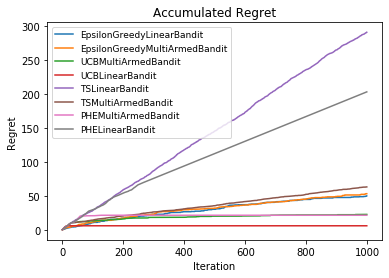

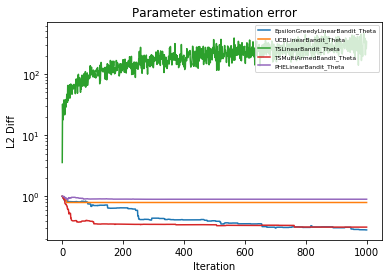

{'EpsilonGreedyLinearBandit': [0.340563883336153,
  0.6331681303754713,
  0.9257723774147896,
  0.9257723774147896,
  0.9257723774147896,
  0.9257723774147896,
  1.0243655543567949,
  1.382590686087827,
  1.4836953487723485,
  1.58480001145687,
  1.6859046741413917,
  1.9621689501188584,
  2.30104221285354,
  2.4021468755380617,
  2.5032515382225835,
  2.6043562009071053,
  2.705460863591627,
  2.806565526276149,
  2.9076701889606706,
  3.0893944756418543,
  3.1879876525838595,
  3.1879876525838595,
  3.2890923152683813,
  3.390196977952903,
  3.491301640637425,
  3.5924063033219467,
  3.5924063033219467,
  3.6935109660064684,
  3.7946156286909902,
  3.895720291375512,
  4.330680910810886,
  4.330680910810886,
  4.330680910810886,
  4.330680910810886,
  4.330680910810886,
  4.330680910810886,
  4.330680910810886,
  4.330680910810886,
  4.51240519749207,
  4.51240519749207,
  4.51240519749207,
  4.51240519749207,
  4.51240519749207,
  4.51240519749207,
  4.694129484173254,
  5.033002746

In [852]:
# parser = argparse.ArgumentParser(description = '')
# parser.add_argument('--contextdim', type=int, help='Set dimension of context features.')
# parser.add_argument('--actionset', type=str, help='Set dimension of context features.')
# args = parser.parse_args()
np.random.seed(42)

context_dimension = 30


actionset = "basis_vector"  # "basis_vector" or "random"

testing_iterations = 1000
NoiseScale = 0.1  # standard deviation of Gaussian noise
n_articles = 10
n_users = 1
poolArticleSize = None

if actionset == "basis_vector":
    n_articles = context_dimension  # there can be at most context_dimension number of basis vectors

## Set Up Simulation ##
UM = UserManager(context_dimension, n_users, thetaFunc=gaussianFeature, argv={'l2_limit': 1})
users = UM.simulateThetafromUsers()
AM = ArticleManager(context_dimension, n_articles=n_articles, argv={'l2_limit':1})
articles = AM.simulateArticlePool(actionset)

simExperiment = simulateOnlineData(	context_dimension=context_dimension,
                                    testing_iterations=testing_iterations,
                                    plot=True,
                                    articles=articles,
                                    users = users,
                                    noise=lambda: np.random.normal(scale=NoiseScale),
                                    signature=AM.signature,
                                    NoiseScale=NoiseScale,
                                    poolArticleSize=poolArticleSize)

## Initiate Bandit Algorithms ##
algorithms = {}

'''
These two were given. Assume Correct
'''
algorithms['EpsilonGreedyLinearBandit'] = EpsilonGreedyLinearBandit(dimension=context_dimension, lambda_=0.1, epsilon=None)
algorithms['EpsilonGreedyMultiArmedBandit'] = EpsilonGreedyMultiArmedBandit(num_arm=n_articles, epsilon=None)

algorithms['UCBMultiArmedBandit'] = UCBMultiArmedBandit(num_arm=n_articles, epsilon=None, sigma = NoiseScale)
algorithms['UCBLinearBandit'] = UCBLinearBandit(dimension=context_dimension, lambda_=0.1, epsilon=None, alpha = .1)

algorithms['TSLinearBandit'] = ThompsonSamplingLinearBandit(dimension=context_dimension, lambda_=0.1, epsilon=None, sigma = NoiseScale)
algorithms['TSMultiArmedBandit'] = ThompsonSamplingMultiArmedBandit(num_arm=n_articles, epsilon=None, sigma = NoiseScale)


algorithms['PHEMultiArmedBandit'] = PerturbedHistoryExplorationMultiArmedBandit(num_arm=n_articles, epsilon=None, alpha = 5)
algorithms['PHELinearBandit'] = PerturbedHistoryExplorationLinearBandit(dimension=context_dimension, lambda_=0.1, epsilon=None, alpha = 5)


## Run Simulation ##
print("Starting for ", simExperiment.simulation_signature)
simExperiment.runAlgorithms(algorithms)

In [196]:
arms = [9, 3, 1, 8, 4, 2, 0, 5, 7, 6]
ucb = [1.83812337, 1.96805911, 2.12322875, 2.40461054, 2.58700756, 2.56849525, 2.75815333, 2.36213601, 1.97726017, 2.18757918]
np.argmax(ucb)
arms[np.argmax(ucb)]

0